In [546]:
import h5py
import numpy as np
from scipy.fft import fft, ifft, fftfreq
from scipy.integrate import cumtrapz
from scipy.signal import gaussian, tukey
import matplotlib.pyplot as plt

In [411]:
# read daily stacks of waveforms
stack_ds = h5py.File("outputs/stacking/stacks_PIG2_0.01Hz.h5",'r')
tilt_stack_file = h5py.File("outputs/stacking/tilt_stacks_PIG2_0.01Hz.h5",'r')

In [3]:
# read modeled green's functions
gf_ds = h5py.File("greens_functions.h5",'r')

In [4]:
def deconvolve(g,z):
    gf = fft(g)
    zf = fft(z)
    answer = ifft(zf/gf)
    return answer

In [5]:
source_types = ["moment","force"]
source_regions = ["rift_tip","rift_margin","margin"]

In [ ]:
# make axes for plotting
fig,ax = plt.subplots(3,2,figsize=(20,10))
plt.suptitle("Vertical displacement GF deconvolved from integrated HHZ velocity stack",fontsize=20)
fig,ax2 = plt.subplots(3,2,figsize=(20,10))
plt.suptitle("Tilt GF deconvolved from tilt stack",fontsize=20)
fig,ax3 = plt.subplots(3,2,figsize=(20,10))
plt.suptitle("Tilt GF deconvolved from HHR stack converted to tilt",fontsize=20)
fig,ax4 = plt.subplots(3,2,figsize=(20,10))
plt.suptitle("Radial velocity GF deconvolved from HHR velocity stack",fontsize=20)
fig,ax5 = plt.subplots(3,2,figsize=(20,10))
plt.suptitle("Tilt GF deconvolved from HHR velocity stack",fontsize=20)
window = [100,350]

for s in range(len(source_types)):
    for sr in range(len(source_regions)):
        
        # deconvolution of vertical green's function from vertical stack
        #g = np.array(ds["/"+source_regions[sr]+"/"+source_types[0]+"/g"]).flatten() + np.array(ds["/"+source_regions[sr]+"/"+source_types[1]+"/g"]).flatten()
        g = np.array(ds["/"+source_regions[sr]+"/"+source_types[s]+"/g"]).flatten()
        z = np.array(stack_file[source_regions[sr]+"_stack"])[0].flatten()
        z = cumtrapz(z,dx=1/2.1)
        stf = deconvolve(g,z)
        ax[sr][s].plot(stf)
        ax[sr][s].set_xlim(window)
        ax[sr][s].set_title(source_regions[sr] + " " + source_types[s])
        
        # deconvolution of tilt greens function from tilt stack
        g_tilt = np.array(ds["/"+source_regions[sr]+"/"+source_types[s]+"/g_tilt"]).flatten()
        r_tilt = np.array(tilt_stack_file[source_regions[sr]+"_stack"]).flatten()
        stf_tilt = deconvolve(g_tilt,r_tilt[:1050])
        ax2[sr][s].plot(stf_tilt,'orange')
        ax2[sr][s].set_xlim(window)
        ax2[sr][s].set_title(source_regions[sr] + " " + source_types[s])
        
        # deconvolution of tilt greens function from radial velocity stack converted to tilt
        #g_tilt = np.array(ds["/"+source_regions[sr]+"/"+source_types[0]+"/g_tilt"]).flatten() + np.array(ds["/"+source_regions[sr]+"/"+source_types[1]+"/g_tilt"]).flatten()
        g_tilt = np.array(ds["/"+source_regions[sr]+"/"+source_types[s]+"/g_tilt"]).flatten()
        r = np.array(stack_file[source_regions[sr]+"_stack"])[1].flatten()
        r_tilt = np.gradient(r,1/2.1)/9.8
        stf_tilt = deconvolve(g_tilt,r_tilt[:1050])
        ax3[sr][s].plot(stf_tilt,'orange')
        ax3[sr][s].set_xlim(window)
        ax3[sr][s].set_title(source_regions[sr] + " " + source_types[s])
        
        # deconvolution of radial velocity greens function from radial velocity stack
        g_horz = np.array(ds["/"+source_regions[sr]+"/"+source_types[s]+"/g_horz"]).flatten()
        r = np.array(stack_file[source_regions[sr]+"_stack"])[1].flatten()
        stf_tilt = deconvolve(g_horz,r[:1050])
        ax4[sr][s].plot(stf_tilt,'orange')
        ax4[sr][s].set_xlim(window)
        ax4[sr][s].set_title(source_regions[sr] + " " + source_types[s])
        
        # deconvolution of tilt greens function from radial velocity stack
        g_tilt = np.array(ds["/"+source_regions[sr]+"/"+source_types[s]+"/g_tilt"]).flatten()
        r = np.array(stack_file[source_regions[sr]+"_stack"])[1].flatten()
        stf_tilt = deconvolve(g_tilt,r[:1050])
        ax5[sr][s].plot(stf_tilt,'orange')
        ax5[sr][s].set_xlim(window)
        ax5[sr][s].set_title(source_regions[sr] + " " + source_types[s])
        
plt.show()
#plt.savefig("decon.png")

In [624]:
def plot_deconvolution(stack_ds,gf_ds,dt,source_region):
    fig,ax = plt.subplots(3,3,figsize=(30,10),gridspec_kw={'width_ratios': [4,4,5],'height_ratios': [5,1,5]})
    t = np.arange(0,500,dt)
    
    # get the stack and green's functions from file, taper the stack, then deconvolve both green's functions
    z = np.array(stack_ds[source_region+"_stack"])[0].flatten()
    z = cumtrapz(z,dx=dt)
    win = tukey(1050,0.6)
    z = win*z
    gf_moment = np.array(gf_ds["/"+source_region+"/moment/g"]).flatten()
    stf_moment = deconvolve(gf_moment,z)
    gf_force = np.array(gf_ds["/"+source_region+"/force/g"]).flatten()
    stf_force = deconvolve(gf_force,z)

    # plot moment gf
    ax[0][0].plot(t,gf_moment,color='k',linewidth=3)
    ax[0][0].set_title("     Moment Green's function",fontsize=30)
    ax[0][0].set_ylabel("Moment$^{-1}$seconds$^{-1}$ $(\dfrac{N*m}{m^2}*s)^{-1}$ ",fontsize=20)
    ax[0][0].set_xlim((0,500))
    ax[0][0].tick_params(axis='x',labelsize=20)
    ax[0][0].tick_params(axis='y',labelsize=20)
    ax[0][0].yaxis.offsetText.set_fontsize(20)

    # plot moment stf
    ax[0][1].plot(t[:130],np.real(stf_moment)[150:280],color='k',linewidth=3)
    ax[0][1].set_title("     Moment source time function",fontsize=30)
    ax[0][1].set_ylabel("Moment $(\dfrac{N*m}{m^2})$",fontsize=20)
    ax[0][1].set_xlim((0,50))
    ax[0][1].tick_params(axis='x',labelsize=20)
    ax[0][1].tick_params(axis='y',labelsize=20)
    ax[0][1].yaxis.offsetText.set_fontsize(20)
    
    # plot 3rd derivative of gaussian
    gaussian_3 = np.gradient(np.gradient(np.gradient(gaussian(30,std=3.5))))
    gaussian_3 = np.concatenate((np.zeros(10),gaussian_3,np.zeros(10)))
    gaussian_3_scaled = gaussian_3/max(abs(gaussian_3))*max(abs(np.real(stf_moment[150:280]-stf_moment[150])))
    gaussian_3_scaled_offset = gaussian_3_scaled + np.real(stf_moment[150]) 
    ax[0][1].plot(gaussian_3_scaled_offset,linewidth = 3)

    # plot force gf
    ax[2][0].plot(t,gf_force*1000,color='k',linewidth=3)
    ax[2][0].set_title("  Pressure Green's function",fontsize=30)
    ax[2][0].set_ylabel("Pressure$^{-1}$seconds$^{-1}$ $(kPa*s)^{-1}$",fontsize=20)
    ax[2][0].set_xlabel("Time (s)",fontsize=20)
    ax[2][0].set_xlim((0,500))
    ax[2][0].tick_params(axis='x',labelsize=20)
    ax[2][0].tick_params(axis='y',labelsize=20)
    ax[2][0].yaxis.offsetText.set_fontsize(20)

    # add convolution operator and equal sign to plot
    ax[1][0].set_visible(0)
    ax_twin = ax[1][0].twinx()
    ax_twin.set_yticks([])
    ax_twin.xaxis.set_visible(False)
    plt.setp(ax_twin.spines.values(), visible=False)
    ax_twin.set_ylabel("*",fontsize=80,rotation=0)
    ax_twin.yaxis.set_label_coords(1.175,1)
    ax[1][1].set_visible(0)
    ax_twin = ax[1][1].twinx()
    ax_twin.set_yticks([])
    ax_twin.xaxis.set_visible(False)
    plt.setp(ax_twin.spines.values(), visible=False)
    ax_twin.set_ylabel("=",fontsize=80,rotation=0)
    ax_twin.yaxis.set_label_coords(1.05,1) 

    # plot force stf
    ax[2][1].plot(t[:130],np.real(stf_force)[150:280]/1000,color='k',linewidth=3)
    ax[2][1].set_title("Pressure source time function",fontsize=30)
    ax[2][1].set_ylabel("Pressure (kPa)",fontsize=20)
    ax[2][1].set_xlabel("Time (s)",fontsize=20)
    ax[2][1].set_xlim((0,50))
    ax[2][1].tick_params(axis='x',labelsize=20)
    ax[2][1].tick_params(axis='y',labelsize=20)
    
    # plot 2nd derivative of gaussian
    gaussian_2 = np.gradient(np.gradient(gaussian(30,std=3.5)))
    gaussian_2 = np.concatenate((np.zeros(10),gaussian_2,np.zeros(10)))
    gaussian_2_scaled = gaussian_2/max(abs(gaussian_2))*max(abs(np.real(stf_force[150:280]/1000)))
    gaussian_2_scaled_offset = gaussian_2_scaled + np.real(stf_force[150]/1000) 
    ax[2][1].plot(gaussian_2_scaled_offset,linewidth = 3)
    
    gs = ax[1, 2].get_gridspec()
    # remove the underlying axes
    for axis in ax[:, -1]:
        axis.remove()
    ax_big = fig.add_subplot(gs[:, -1])

    # plot stack
    ax_big.plot(t[:600],z[150:750],color="#d95f02",linewidth=3)
    ax_big.set_xlim((0,250))
    ax_big.set_title("Rift tip stack",fontsize=30)
    ax_big.set_ylabel("Displacement (m)",fontsize=20)
    ax_big.set_xlabel("Time (s)",fontsize=20)
    ax_big.tick_params(axis='x',labelsize=20)
    ax_big.tick_params(axis='y',labelsize=20)
    ax_big.yaxis.offsetText.set_fontsize(20)
    plt.tight_layout()
    plt.savefig("outputs/figures/deconvolution.png",dpi=60)


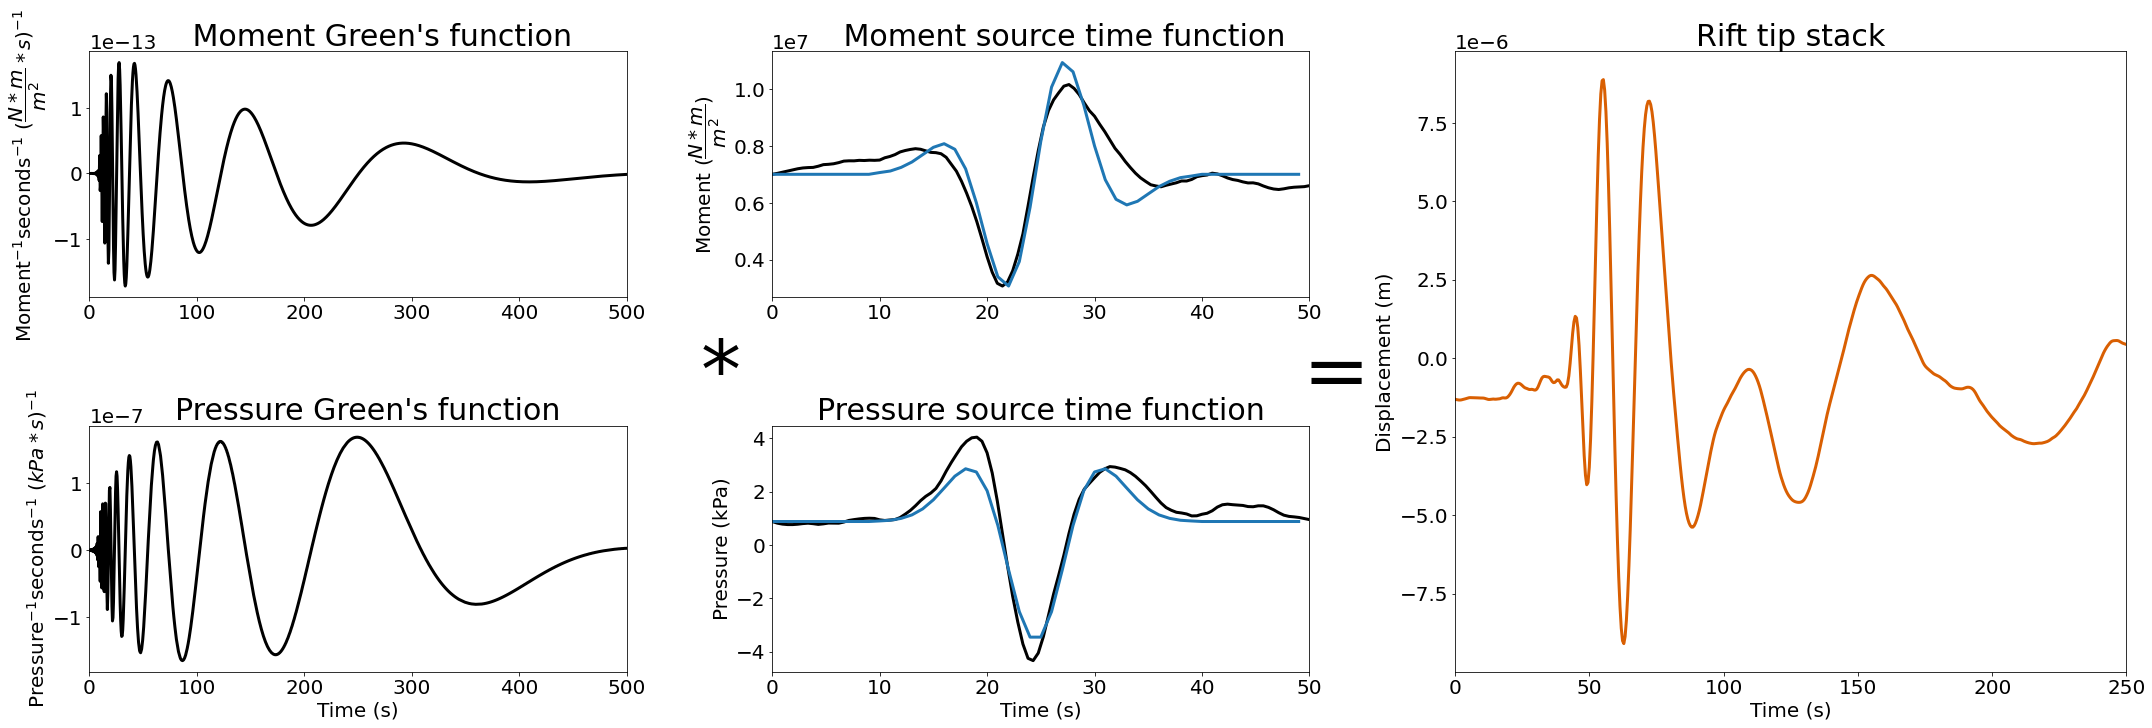

In [625]:
plot_deconvolution(stack_ds,gf_ds,1/2.1,"rift_tip")

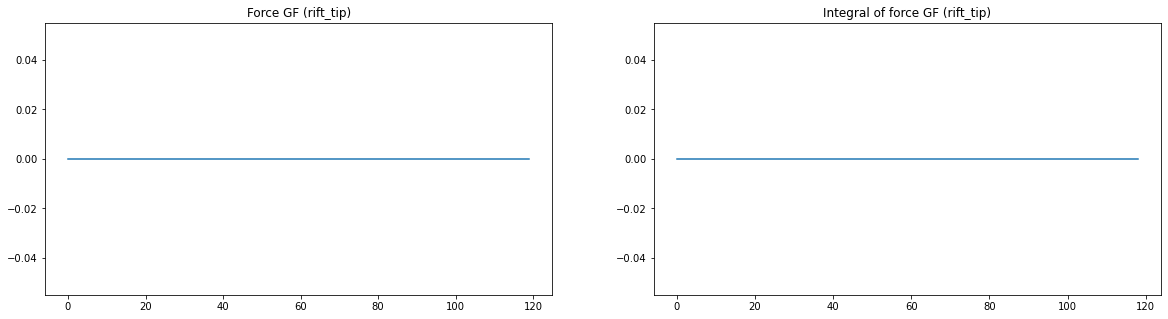

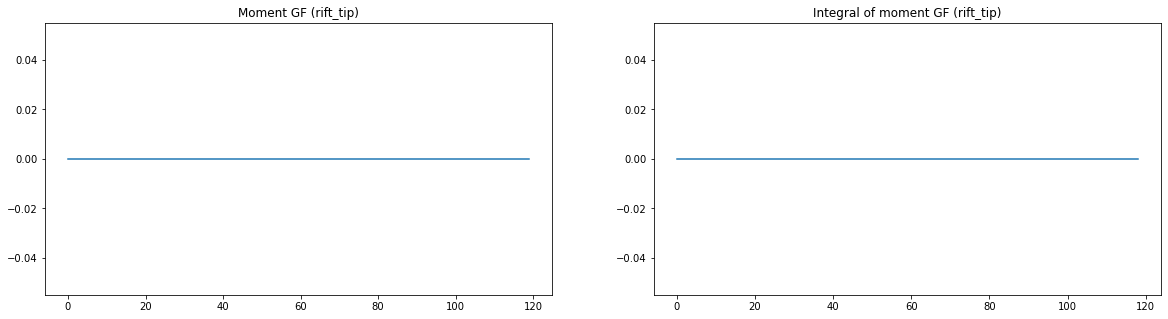

In [407]:
# plot stf and its integral

from scipy.signal import detrend

source_region = "rift_tip"
g_moment = np.array(gf_ds["/"+source_region+"/moment/g"]).flatten()
z = np.array(stack_ds[source_region+"_stack"])[0].flatten()
z = cumtrapz(z,dx=1/2.1)
stf_moment = deconvolve(g_moment,z)

g_force = np.array(gf_ds["/"+source_region+"/force/g"]).flatten()
stf_force = deconvolve(g_force,z)

# plot force stf and derivative
fig,ax = plt.subplots(1,2,figsize=(20,5))
ax[0].plot(detrend(np.real(stf_force[160:280])))
ax[0].set_title("Force GF (" + source_region + ")")
ax[1].plot(cumtrapz(detrend(np.real(stf_force[160:280])),dx=1/2.1))
ax[1].set_title("Integral of force GF (" + source_region + ")")
plt.show()

# plot moment stf and derivative
fig,ax = plt.subplots(1,2,figsize=(20,5))
ax[0].plot(detrend(np.real(stf_moment[160:280])))
ax[0].set_title("Moment GF (" + source_region + ")")
ax[1].plot(cumtrapz(detrend(np.real(stf_moment[160:280])),dx=1/2.1))
ax[1].set_title("Integral of moment GF (" + source_region + ")")
plt.show()

In [535]:
from scipy.signal import tukey

z = np.array(tilt_stack_file["rift_tip_stack"])
z = cumtrapz(z,dx=1/2.1)

win = tukey(1050,0.6)
z = win*z

gf_moment = np.array(gf_ds["/"+source_region+"/moment/g_tilt"]).flatten()
stf_moment = deconvolve(gf_moment,z)
gf_force = np.array(gf_ds["/"+source_region+"/force/g_tilt"]).flatten()
stf_force = deconvolve(gf_force,z)

In [531]:
z = np.array(stack_ds["rift_tip_stack"])[0].flatten()
z = cumtrapz(z,dx=1/2.1)

win = tukey(1050,0.6)
#z = win*z

gf_moment = np.array(gf_ds["/"+source_region+"/moment/g"]).flatten()
stf_moment = deconvolve(gf_moment,z)
gf_force = np.array(gf_ds["/"+source_region+"/force/g"]).flatten()
stf_force = deconvolve(gf_force,z)

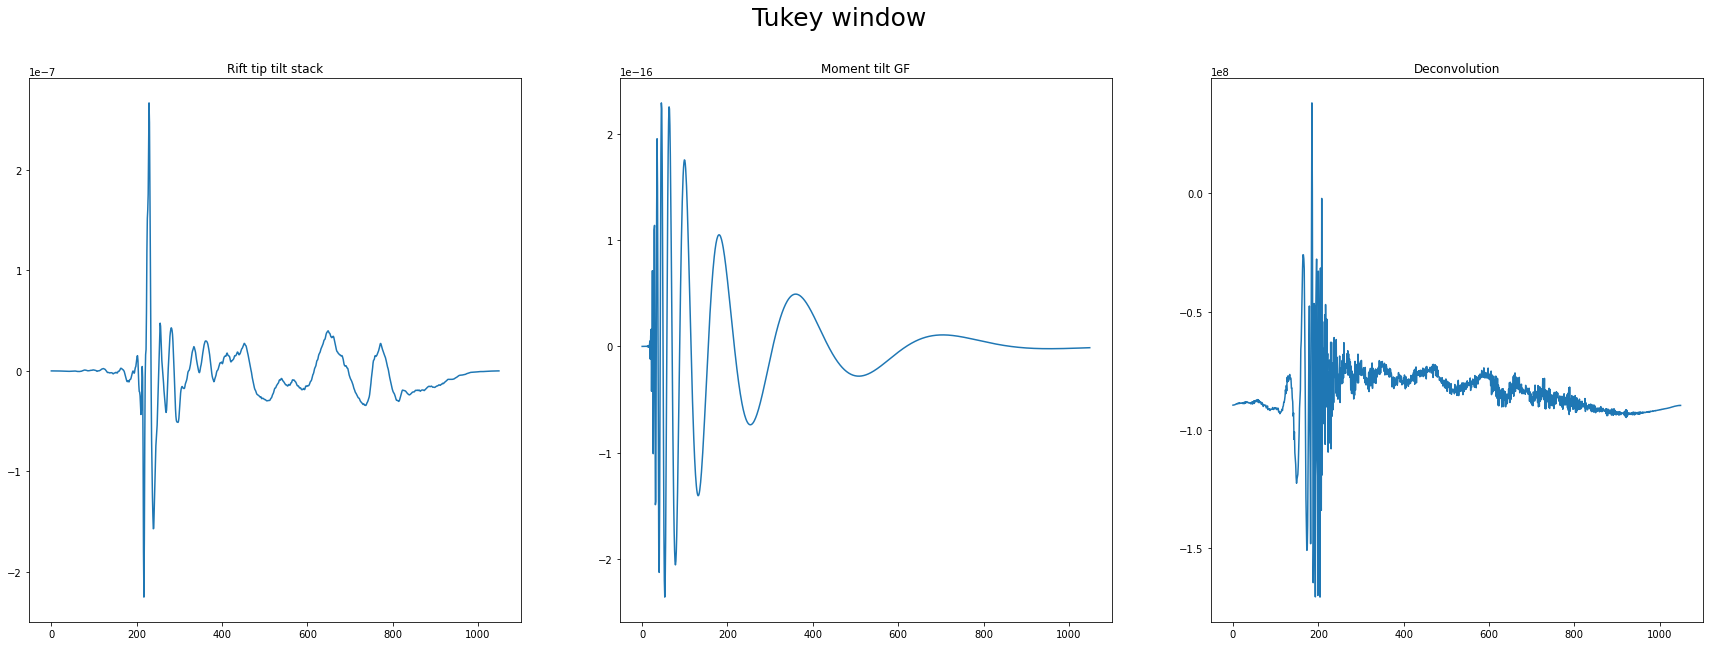

In [536]:
fig,ax = plt.subplots(1,3,figsize=(30,10))
ax[0].plot(z)
ax[0].set_title("Rift tip tilt stack")
ax[1].plot(gf_moment)
ax[1].set_title("Moment tilt GF")
ax[2].plot(np.real(stf_moment))
ax[2].set_title("Deconvolution")
plt.suptitle("Tukey window",fontsize=25)
plt.savefig("tilt_decon_with_taper.png")

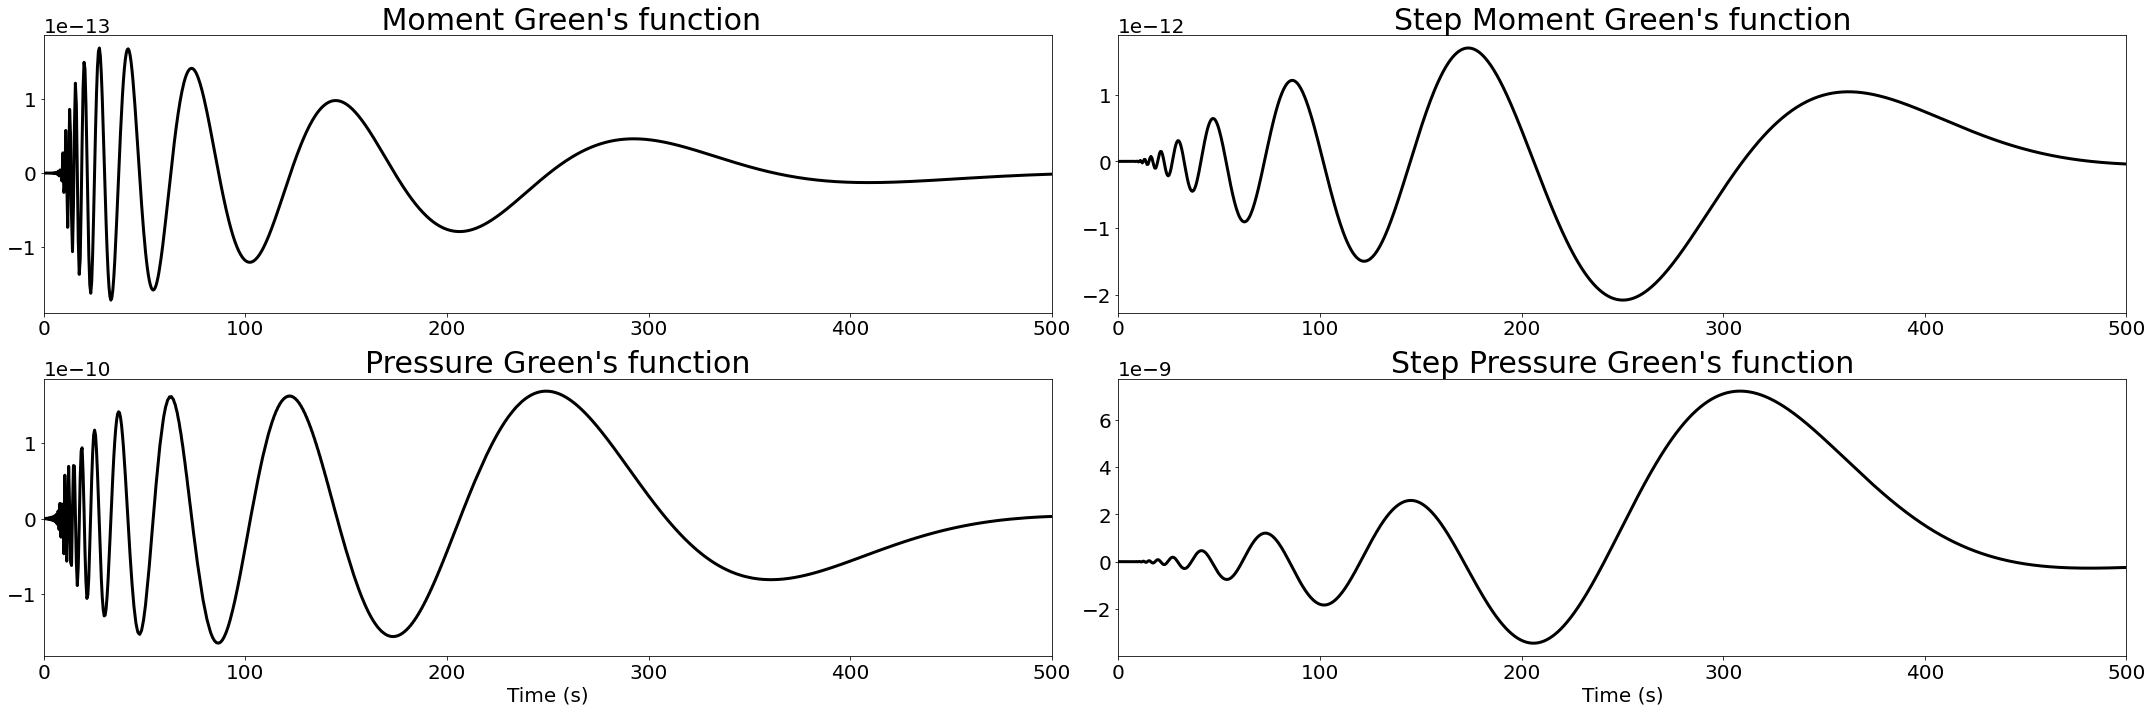

In [630]:
source_region = "rift_tip"
dt = 1/2.1

fig,ax = plt.subplots(2,2,figsize=(30,10))
t = np.arange(0,500,dt)

# get the stack and green's functions from file, taper the stack, then deconvolve both green's functions
z = np.array(stack_ds[source_region+"_stack"])[0].flatten()
z = cumtrapz(z,dx=dt)
win = tukey(1050,0.6)
z = win*z

# get the green's function
gf_moment = np.array(gf_ds["/"+source_region+"/moment/g"]).flatten()
gf_force = np.array(gf_ds["/"+source_region+"/force/g"]).flatten()

# take time derivative of both
gf_step_moment = cumtrapz(gf_moment,dx=dt)
gf_step_force = cumtrapz(gf_force,dx=dt)

# plot moment gf
ax[0][0].plot(t,gf_moment,color='k',linewidth=3)
ax[0][0].set_title("     Moment Green's function",fontsize=30)
#ax[0][0].set_ylabel("Moment$^{-1}$seconds$^{-1}$ $(\dfrac{N*m}{m^2}*s)^{-1}$ ",fontsize=20)
ax[0][0].set_xlim((0,500))
ax[0][0].tick_params(axis='x',labelsize=20)
ax[0][0].tick_params(axis='y',labelsize=20)
ax[0][0].yaxis.offsetText.set_fontsize(20)

# plot step moment gf
ax[0][1].plot(t[:-1],gf_step_moment,color='k',linewidth=3)
ax[0][1].set_title("Step Moment Green's function",fontsize=30)
#ax[0][0].set_ylabel("Moment$^{-1}$seconds$^{-1}$ $(\dfrac{N*m}{m^2}*s)^{-1}$ ",fontsize=20)
ax[0][1].set_xlim((0,500))
ax[0][1].tick_params(axis='x',labelsize=20)
ax[0][1].tick_params(axis='y',labelsize=20)
ax[0][1].yaxis.offsetText.set_fontsize(20)

# plot force gf
ax[1][0].plot(t,gf_force,color='k',linewidth=3)
ax[1][0].set_title("  Pressure Green's function",fontsize=30)
#ax[1][0].set_ylabel("Pressure$^{-1}$seconds$^{-1}$ $(kPa*s)^{-1}$",fontsize=20)
ax[1][0].set_xlabel("Time (s)",fontsize=20)
ax[1][0].set_xlim((0,500))
ax[1][0].tick_params(axis='x',labelsize=20)
ax[1][0].tick_params(axis='y',labelsize=20)
ax[1][0].yaxis.offsetText.set_fontsize(20)

# plot force gf
ax[1][1].plot(t[:-1],gf_step_force,color='k',linewidth=3)
ax[1][1].set_title("Step Pressure Green's function",fontsize=30)
#ax[1][0].set_ylabel("Pressure$^{-1}$seconds$^{-1}$ $(kPa*s)^{-1}$",fontsize=20)
ax[1][1].set_xlabel("Time (s)",fontsize=20)
ax[1][1].set_xlim((0,500))
ax[1][1].tick_params(axis='x',labelsize=20)
ax[1][1].tick_params(axis='y',labelsize=20)
ax[1][1].yaxis.offsetText.set_fontsize(20)

plt.tight_layout()
plt.savefig("delta_GF_vs_step_GF.png")
